In [78]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt

In [79]:
# load a file by name or from a buffer
mesh = trimesh.load_mesh(r".\Storage\currentModel.glb")
# to keep the raw data intact, disable any automatic processing
# mesh = trimesh.load_mesh('../models/featuretype.STL', process=False)

In [80]:
mesh = mesh.apply_scale(100.0)

In [81]:
mesh.show()

In [82]:
# Compute the oriented bounding box (OBB)
obb = mesh.bounding_box_oriented

# Get the transformation matrix to align OBB to world axes
T = np.linalg.inv(obb.primitive.transform)

# Apply transformation to align to XYZ axes
mesh.apply_transform(T)

# Create a rotation matrix for 90 degrees around Z-axis (clockwise/right)
rotation_z = np.array([
    [0, 1, 0, 0],
    [-1, 0, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
])

# Apply the rotation
mesh.apply_transform(rotation_z)

# Get bounds of the aligned mesh
bounds = mesh.bounds

# Find the Z-coordinate of the bottom face
bottom_z = bounds[0][2]

# Apply translation to move bottom to Z=0
mesh.apply_translation([0, 0, -bottom_z])

# Visualize the result
mesh.show()

In [83]:
# Translate the mesh to position it at origin (0,0,0)
mesh_bounds = mesh.bounds
mesh_center = (mesh_bounds[0] + mesh_bounds[1]) / 2

# Calculate translation to move center to origin
translation_to_origin = -mesh_center

# Apply translation to move mesh to origin
mesh.apply_translation(translation_to_origin)

print(f"Mesh translated by: {translation_to_origin}")
print(f"New mesh bounds: {mesh.bounds}")
print(f"New mesh center: {(mesh.bounds[0] + mesh.bounds[1]) / 2}")

# Visualize the mesh at origin
mesh.show()

Mesh translated by: [-5.68434189e-14 -0.00000000e+00 -1.09090594e+03]
New mesh bounds: [[ -632.10123759  -513.88039589 -1090.90594016]
 [  632.10123759   513.88039589  1090.90594016]]
New mesh center: [0. 0. 0.]


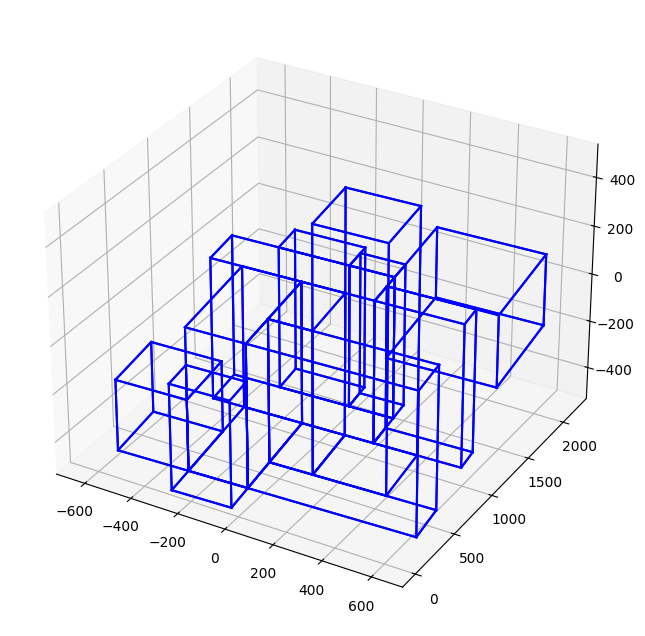

In [84]:
# Flatten onto XY-plane
min_z = mesh.bounds[0][2]
mesh.apply_translation([0, 0, -min_z])

# Find boundary edges (edges with only one face)
edges = mesh.edges_unique
# Calculate face count for each edge
edges_face_count = []
for edge in edges:
    face_count = 0
    for face in mesh.faces:
        if (edge[0] in face and edge[1] in face):
            face_count += 1
    edges_face_count.append(face_count)
edges_face_count = np.array(edges_face_count)
boundary_edges = edges[edges_face_count == 1]

# Plot boundary edges and ground plane
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for edge in boundary_edges:
    p1, p2 = mesh.vertices[edge[0]], mesh.vertices[edge[1]]
    xs, ys, zs = zip(p1, p2)
    ax.plot(xs, zs, ys, color='blue')

# Add ground plane
# plane_size = max(mesh.extents[0], mesh.extents[1]) * 1.5
# x = np.linspace(-plane_size/2, plane_size/2, 10)
# y = np.linspace(-plane_size/2, plane_size/2, 10)
# x, y = np.meshgrid(x, y)
# z = np.zeros_like(x)
# ax.plot_surface(x, y, z, alpha=0.15, color='gray', edgecolor='none')

# ax.set_title("Boundary Edges with Ground Plane")
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# plt.tight_layout()
# plt.show()

In [85]:
import pandas as pd

# Extract the vertices of boundary edges
boundary_vertices = []
for edge in boundary_edges:
    v1, v2 = mesh.vertices[edge[0]], mesh.vertices[edge[1]]
    boundary_vertices.append(v1)
    boundary_vertices.append(v2)

# Convert to numpy array for easier processing
boundary_vertices = np.array(boundary_vertices)

# Calculate edge lengths and store with edge information
edge_data = []
for i, edge in enumerate(boundary_edges):
    v1, v2 = mesh.vertices[edge[0]], mesh.vertices[edge[1]]
    length = round(np.linalg.norm(v2 - v1),1)
    edge_data.append([f"Edge {i}", f"{edge[0]}-{edge[1]}", length])

# Create DataFrame for table display
edge_df = pd.DataFrame(edge_data, columns=['Edge ID', 'Vertices', 'Length'])
print(edge_df)



      Edge ID Vertices  Length
0      Edge 0      0-1   361.7
1      Edge 1      0-2   199.2
2      Edge 2      1-3   199.2
3      Edge 3      2-3   361.7
4      Edge 4      4-5   600.0
..        ...      ...     ...
259  Edge 259  258-259   300.0
260  Edge 260  260-261   451.1
261  Edge 261  260-262   843.9
262  Edge 262  261-263   843.9
263  Edge 263  262-263   451.1

[264 rows x 3 columns]


In [86]:
# Process edges based on length criteria
processed_edges = []

for i, edge in enumerate(boundary_edges):
        v1, v2 = mesh.vertices[edge[0]], mesh.vertices[edge[1]]
        length = np.linalg.norm(v2 - v1)
        
        if 4.0 < length < 6.0:
                # Don't divide - keep as single edge
                processed_edges.append({
                        'original_edge': f"Edge {i}",
                        'segments': [{'start': v1, 'end': v2, 'length': length}]
                })
        elif length >= 6.0:
                # Divide edge to get segments between 4.0 and 6.0
                num_divisions = int(np.ceil(length / 6.0))
                segment_length = length / num_divisions
                
                segments = []
                for j in range(num_divisions):
                        t_start = j / num_divisions
                        t_end = (j + 1) / num_divisions
                        
                        seg_start = v1 + t_start * (v2 - v1)
                        seg_end = v1 + t_end * (v2 - v1)
                        seg_length = np.linalg.norm(seg_end - seg_start)
                        
                        segments.append({
                                'start': seg_start,
                                'end': seg_end,
                                'length': seg_length
                        })
                
                processed_edges.append({
                        'original_edge': f"Edge {i}",
                        'segments': segments
                })
        else:
                # Length <= 4.0, keep as is
                processed_edges.append({
                        'original_edge': f"Edge {i}",
                        'segments': [{'start': v1, 'end': v2, 'length': length}]
                })

# Display results
for edge_info in processed_edges:
        print(f"{edge_info['original_edge']}: {len(edge_info['segments'])} segment(s)")
        for j, seg in enumerate(edge_info['segments']):
                print(f"  Segment {j+1}: Length = {seg['length']:.1f}")
    

Edge 0: 61 segment(s)
  Segment 1: Length = 5.9
  Segment 2: Length = 5.9
  Segment 3: Length = 5.9
  Segment 4: Length = 5.9
  Segment 5: Length = 5.9
  Segment 6: Length = 5.9
  Segment 7: Length = 5.9
  Segment 8: Length = 5.9
  Segment 9: Length = 5.9
  Segment 10: Length = 5.9
  Segment 11: Length = 5.9
  Segment 12: Length = 5.9
  Segment 13: Length = 5.9
  Segment 14: Length = 5.9
  Segment 15: Length = 5.9
  Segment 16: Length = 5.9
  Segment 17: Length = 5.9
  Segment 18: Length = 5.9
  Segment 19: Length = 5.9
  Segment 20: Length = 5.9
  Segment 21: Length = 5.9
  Segment 22: Length = 5.9
  Segment 23: Length = 5.9
  Segment 24: Length = 5.9
  Segment 25: Length = 5.9
  Segment 26: Length = 5.9
  Segment 27: Length = 5.9
  Segment 28: Length = 5.9
  Segment 29: Length = 5.9
  Segment 30: Length = 5.9
  Segment 31: Length = 5.9
  Segment 32: Length = 5.9
  Segment 33: Length = 5.9
  Segment 34: Length = 5.9
  Segment 35: Length = 5.9
  Segment 36: Length = 5.9
  Segment 37: L

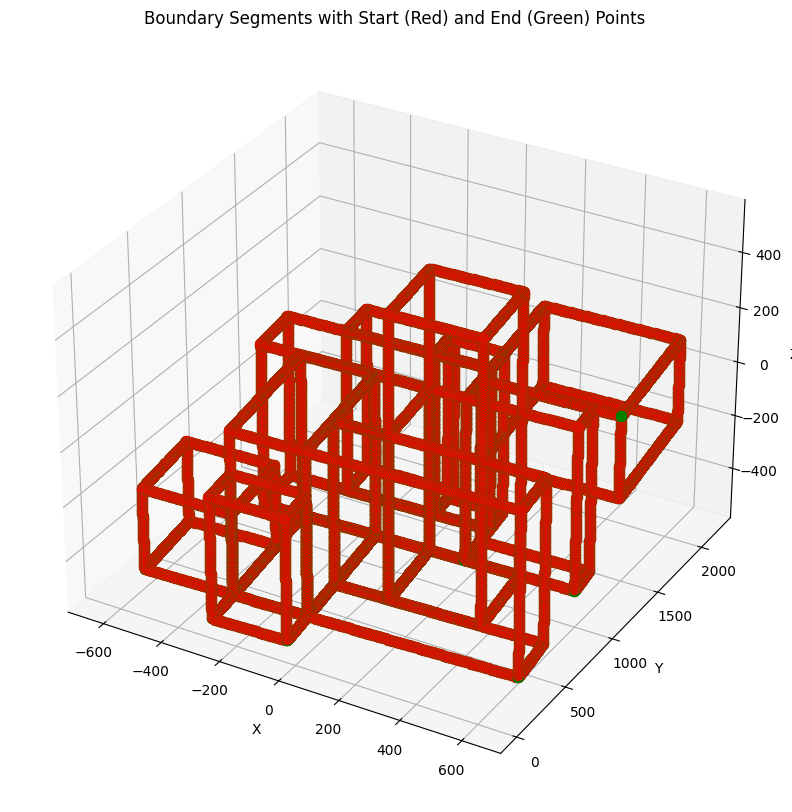

In [87]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot all segments with different colors and add endpoint markers
for edge_info in processed_edges:
    for j, seg in enumerate(edge_info['segments']):
        start = seg['start']
        end = seg['end']
        
        # Plot the segment line
        ax.plot([start[0], end[0]], [start[2], end[2]], [start[1], end[1]], 
                'b-', linewidth=2, alpha=0.7)
        
        # Plot start point
        ax.scatter(start[0], start[2], start[1], c='red', s=50, alpha=0.8)
        
        # Plot end point
        ax.scatter(end[0], end[2], end[1], c='green', s=50, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y') 
ax.set_zlabel('Z')
ax.set_title('Boundary Segments with Start (Red) and End (Green) Points')
plt.show()

In [88]:
# Remove overlapping points by finding unique points within tolerance
def remove_overlapping_points(points, tolerance=1e-5):
    unique_points = []
    
    for point in points:
        is_duplicate = False
        for existing_point in unique_points:
            # Calculate distance between points
            dist = np.linalg.norm(np.array(point) - np.array(existing_point))
            if dist < tolerance:
                is_duplicate = True
                break
        
        if not is_duplicate:
            unique_points.append(point)
    
    return unique_points

# Extract all segment endpoints
all_points = []
for edge_info in processed_edges:
    for segment in edge_info['segments']:
        all_points.append(segment['start'])
        all_points.append(segment['end'])

# Remove overlapping points
unique_points = remove_overlapping_points(all_points)

print(f"Original points: {len(all_points)}")
print(f"Unique points after removing overlaps: {len(unique_points)}")

Original points: 40136
Unique points after removing overlaps: 9302


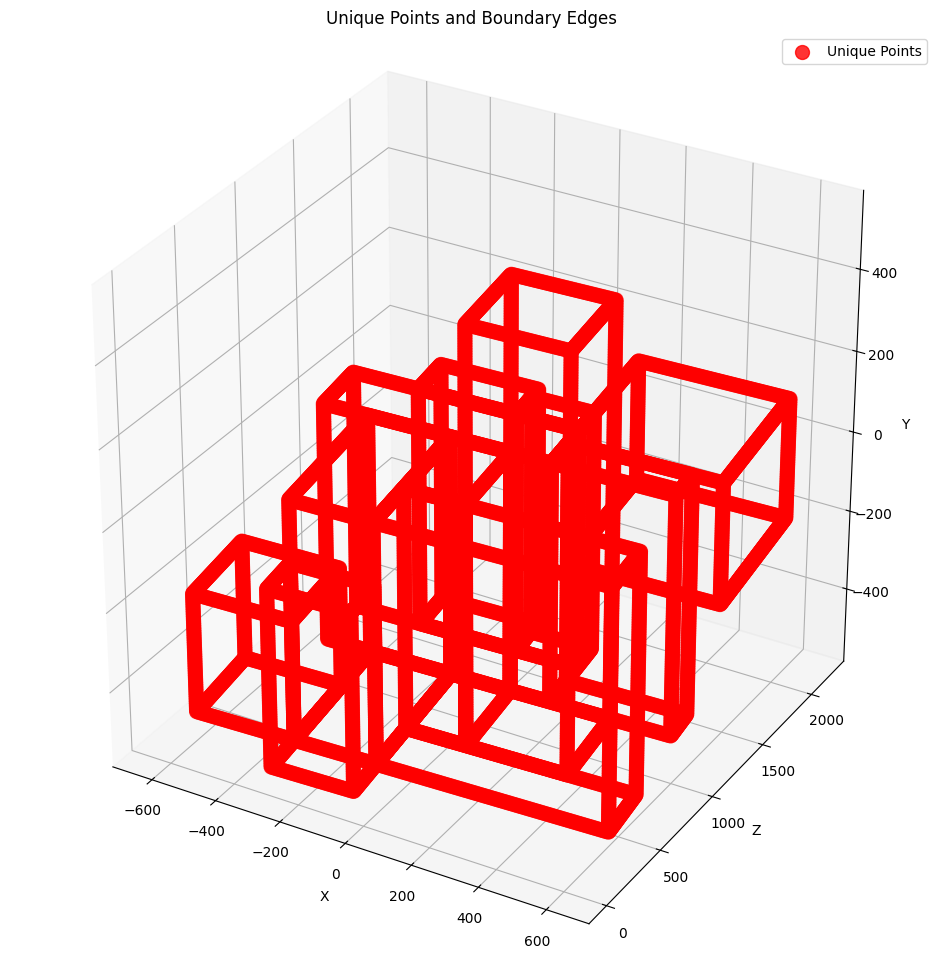

In [89]:
# Create a 3D visualization of points and boundary edges
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot all unique points
unique_points_array = np.array(unique_points)
ax.scatter(unique_points_array[:, 0], unique_points_array[:, 2], unique_points_array[:, 1], 
          c='red', s=100, alpha=0.8, label='Unique Points')

# Plot boundary edges
for edge in boundary_edges:
    v1, v2 = mesh.vertices[edge[0]], mesh.vertices[edge[1]]
    ax.plot([v1[0], v2[0]], [v1[2], v2[2]], [v1[1], v2[1]], 
            'b-', linewidth=2, alpha=0.7)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Z') 
ax.set_zlabel('Y')
ax.set_title('Unique Points and Boundary Edges')
ax.legend()

# Set equal aspect ratio
ax.set_box_aspect([1,1,1])

plt.show()

In [90]:
# Store points and edges as numpy arrays
points = np.array(unique_points)
edges = boundary_edges

In [ ]:
# Connect points with their perpendicular opposites based on axis alignment
connections = []

# For each point, find its perpendicular opposite
for i, point in enumerate(points):
    x, y, z = point
    
    # Find points that share the same coordinates on two axes
    for j, other_point in enumerate(points):
        if i == j:
            continue
            
        ox, oy, oz = other_point
        
        # Check for perpendicular opposites (same on 2 axes, different on 1)
        same_axes = 0
        if abs(x - ox) < 1e-5:  # Same X
            same_axes += 1
        if abs(y - oy) < 1e-5:  # Same Y
            same_axes += 1
        if abs(z - oz) < 1e-5:  # Same Z
            same_axes += 1
            
        # If exactly 2 axes are the same, they are perpendicular opposites
        if same_axes == 2:
            # Avoid duplicate connections
            if (j, i) not in [(conn[1], conn[0]) for conn in connections]:
                connections.append((i, j))

print(f"Found {len(connections)} perpendicular connections")

# Visualize the connections
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot all points
ax.scatter(points[:, 0], points[:, 2], points[:, 1], 
          c='red', s=100, alpha=0.8, label='Points')

# Plot connections
for i, j in connections:
    p1, p2 = points[i], points[j]
    ax.plot([p1[0], p2[0]], [p1[2], p2[2]], [p1[1], p2[1]], 
            'g-', linewidth=2, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('Perpendicular Connections Between Points')
ax.legend()
ax.set_box_aspect([1,1,1])

plt.show()

# # Print connection details
# for idx, (i, j) in enumerate(connections):
#     p1, p2 = points[i], points[j]
#     distance = np.linalg.norm(p2 - p1)
#     print(f"Connection {idx+1}: Point {i} to Point {j}, Distance: {distance:.2f}")

Found 0 intersection points


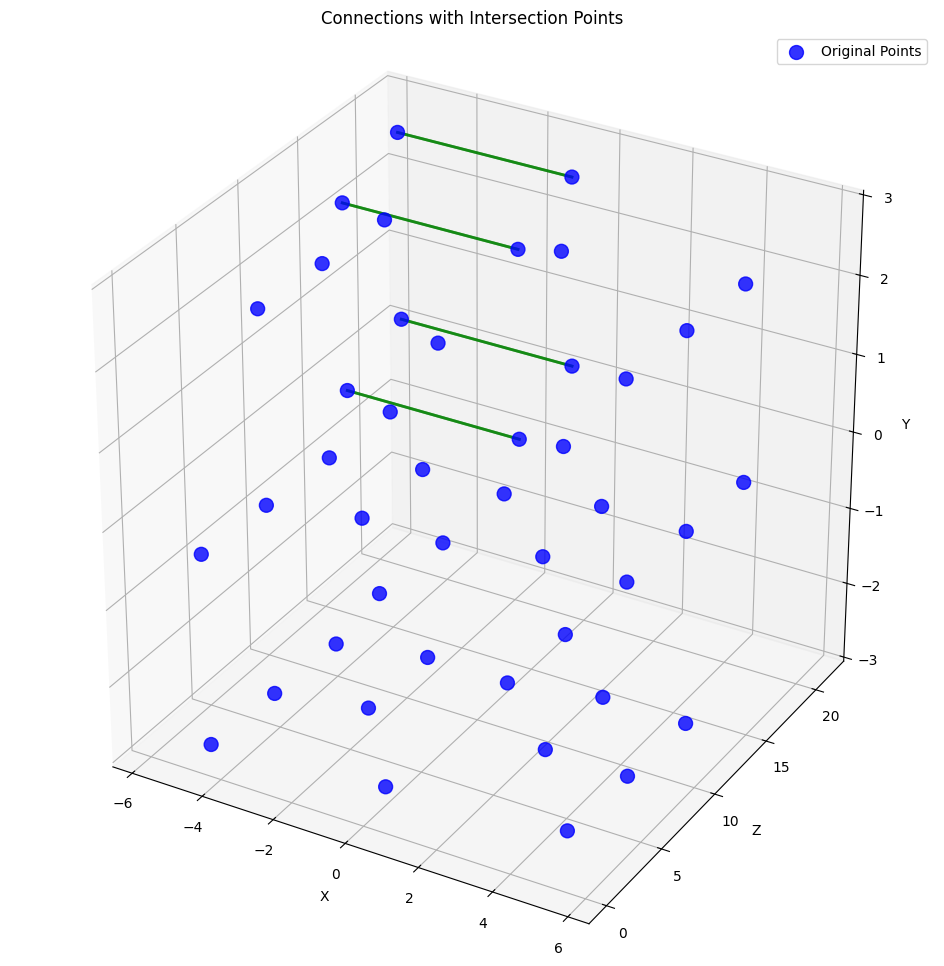

In [ ]:
    # Find intersections between connection lines
intersections = []
tolerance = 1e-6

# Convert connections to line segments for intersection calculation
def lines_intersect_3d(line1_start, line1_end, line2_start, line2_end):
    """Find intersection point of two 3D line segments if it exists"""
    p1, p2 = line1_start, line1_end
    p3, p4 = line2_start, line2_end
    
    # Direction vectors
    d1 = p2 - p1
    d2 = p4 - p3
    
    # Vector between line start points
    w0 = p1 - p3
    
    # Check if lines are parallel
    cross = np.cross(d1, d2)
    if np.linalg.norm(cross) < tolerance:
        return None
    
    # For 3D lines, we need to check if they intersect
    # Using parametric form: P1 + t1*d1 = P3 + t2*d2
    # This gives us: t1*d1 - t2*d2 = P3 - P1 = -w0
    
    # Solve the system using least squares for overdetermined system
    A = np.column_stack([d1, -d2])
    try:
        params = np.linalg.lstsq(A, -w0, rcond=None)[0]
        t1, t2 = params
        
        # Check if intersection is within both line segments
        if 0 <= t1 <= 1 and 0 <= t2 <= 1:
            # Calculate intersection points from both lines
            intersection1 = p1 + t1 * d1
            intersection2 = p3 + t2 * d2
            
            # Check if the points are close enough (within tolerance)
            if np.linalg.norm(intersection1 - intersection2) < tolerance:
                return (intersection1 + intersection2) / 2  # Average for numerical stability
    except:
        pass
    
    return None

# Find all intersections between connection lines
for i, (conn1_start_idx, conn1_end_idx) in enumerate(connections):
    for j, (conn2_start_idx, conn2_end_idx) in enumerate(connections):
        if i >= j:  # Avoid duplicate checks
            continue
            
        line1_start = points[conn1_start_idx]
        line1_end = points[conn1_end_idx]
        line2_start = points[conn2_start_idx]
        line2_end = points[conn2_end_idx]
        
        intersection = lines_intersect_3d(line1_start, line1_end, line2_start, line2_end)
        
        if intersection is not None:
            intersections.append({
                'point': intersection,
                'line1': (conn1_start_idx, conn1_end_idx),
                'line2': (conn2_start_idx, conn2_end_idx),
                'line1_idx': i,
                'line2_idx': j
            })

print(f"Found {len(intersections)} intersection points")

# Visualize connections with intersection points
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot all original points
ax.scatter(points[:, 0], points[:, 2], points[:, 1], 
          c='blue', s=100, alpha=0.8, label='Original Points')

# Plot connections
for i, j in connections:
    p1, p2 = points[i], points[j]
    ax.plot([p1[0], p2[0]], [p1[2], p2[2]], [p1[1], p2[1]], 
            'g-', linewidth=2, alpha=0.7)

# Plot intersection points
if intersections:
    intersection_points = np.array([inter['point'] for inter in intersections])
    ax.scatter(intersection_points[:, 0], intersection_points[:, 2], intersection_points[:, 1], 
              c='red', s=150, alpha=1.0, label='Intersection Points', marker='X')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('Connections with Intersection Points')
ax.legend()
ax.set_box_aspect([1,1,1])

plt.show()

# Print intersection details
for idx, inter in enumerate(intersections):
    print(f"Intersection {idx+1}:")
    print(f"  Point: [{inter['point'][0]:.3f}, {inter['point'][1]:.3f}, {inter['point'][2]:.3f}]")
    print(f"  Between lines: {inter['line1']} and {inter['line2']}")

Original intersections: 0
Unique intersections after removing overlaps: 0


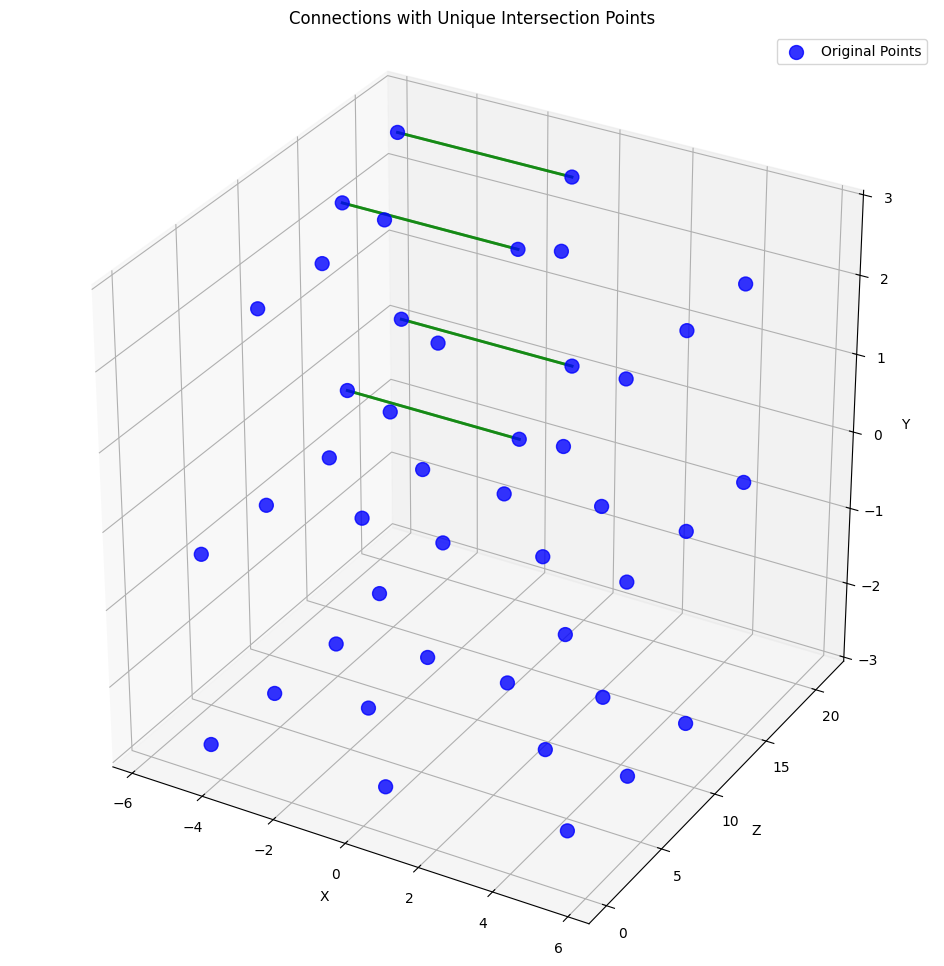

In [ ]:
# Remove overlapping intersection points
def remove_overlapping_intersections(intersections, tolerance=1e-5):
    unique_intersections = []
    
    for intersection in intersections:
        point = intersection['point']
        is_duplicate = False
        
        for existing_intersection in unique_intersections:
            existing_point = existing_intersection['point']
            # Calculate distance between intersection points
            dist = np.linalg.norm(point - existing_point)
            if dist < tolerance:
                is_duplicate = True
                break
        
        if not is_duplicate:
            unique_intersections.append(intersection)
    
    return unique_intersections

# Remove overlapping intersection points
unique_intersections = remove_overlapping_intersections(intersections)

print(f"Original intersections: {len(intersections)}")
print(f"Unique intersections after removing overlaps: {len(unique_intersections)}")

# Visualize the unique intersections
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot all original points
ax.scatter(points[:, 0], points[:, 2], points[:, 1], 
          c='blue', s=100, alpha=0.8, label='Original Points')

# Plot connections
for i, j in connections:
    p1, p2 = points[i], points[j]
    ax.plot([p1[0], p2[0]], [p1[2], p2[2]], [p1[1], p2[1]], 
            'g-', linewidth=2, alpha=0.7)

# Plot unique intersection points
if unique_intersections:
    unique_intersection_points = np.array([inter['point'] for inter in unique_intersections])
    ax.scatter(unique_intersection_points[:, 0], unique_intersection_points[:, 2], unique_intersection_points[:, 1], 
              c='red', s=150, alpha=1.0, label='Unique Intersection Points', marker='X')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('Connections with Unique Intersection Points')
ax.legend()
ax.set_box_aspect([1,1,1])

plt.show()

Original connections: 8
Unique connections after removing overlaps: 4


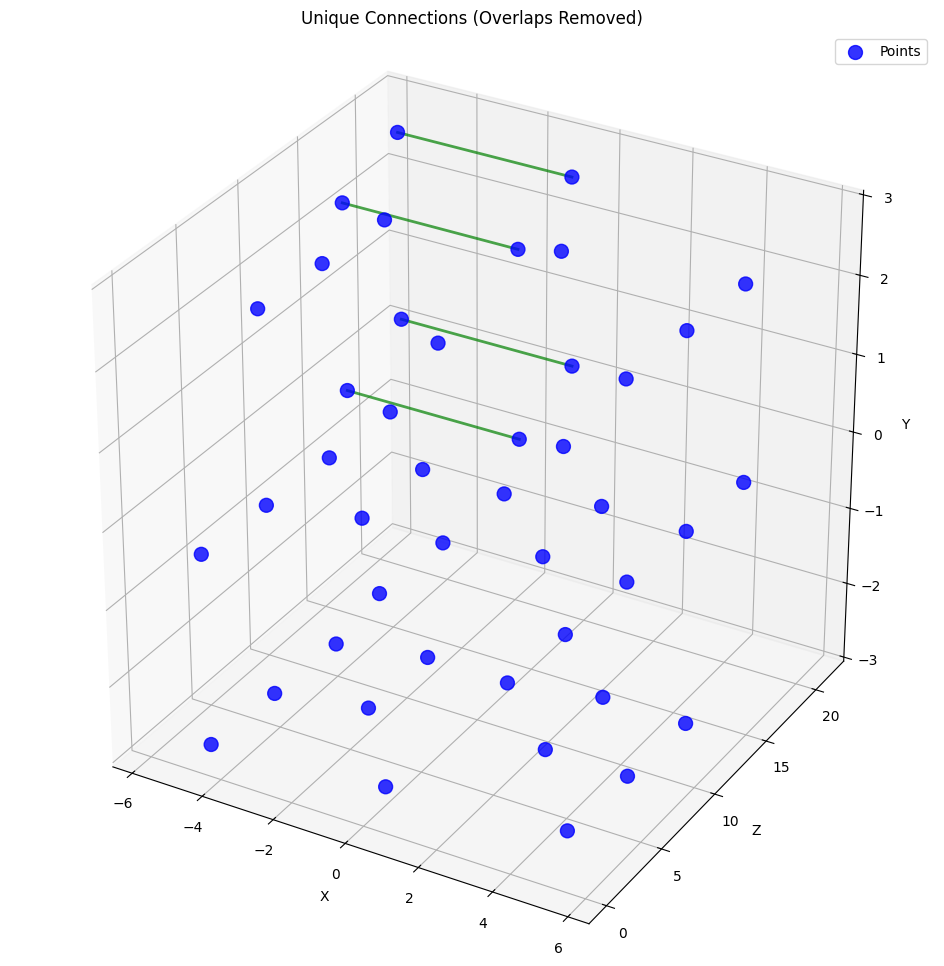

In [ ]:
# Remove overlapping connection lines
def remove_overlapping_connections(connections, points, tolerance=1e-5):
    unique_connections = []
    
    for connection in connections:
        i, j = connection
        p1, p2 = points[i], points[j]
        
        is_duplicate = False
        for existing_connection in unique_connections:
            ei, ej = existing_connection
            ep1, ep2 = points[ei], points[ej]
            
            # Check if lines are the same (either direction)
            if ((np.linalg.norm(p1 - ep1) < tolerance and np.linalg.norm(p2 - ep2) < tolerance) or
                (np.linalg.norm(p1 - ep2) < tolerance and np.linalg.norm(p2 - ep1) < tolerance)):
                is_duplicate = True
                break
        
        if not is_duplicate:
            unique_connections.append(connection)
    
    return unique_connections

# Remove overlapping connections
unique_connections = remove_overlapping_connections(connections, points)

print(f"Original connections: {len(connections)}")
print(f"Unique connections after removing overlaps: {len(unique_connections)}")

# Visualize the unique connections
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot all points
ax.scatter(points[:, 0], points[:, 2], points[:, 1], 
          c='blue', s=100, alpha=0.8, label='Points')

# Plot unique connections
for i, j in unique_connections:
    p1, p2 = points[i], points[j]
    ax.plot([p1[0], p2[0]], [p1[2], p2[2]], [p1[1], p2[1]], 
            'g-', linewidth=2, alpha=0.7)

# Plot unique intersection points if they exist
if unique_intersections:
    unique_intersection_points = np.array([inter['point'] for inter in unique_intersections])
    ax.scatter(unique_intersection_points[:, 0], unique_intersection_points[:, 2], unique_intersection_points[:, 1], 
              c='red', s=150, alpha=1.0, label='Intersection Points', marker='X')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('Unique Connections (Overlaps Removed)')
ax.legend()
ax.set_box_aspect([1,1,1])

plt.show()

In [ ]:
Nodes = unique_intersections
Edges = unique_connections

In [ ]:
# # Remove duplicate structural elements based on start and end coordinates
# def remove_duplicate_elements(elements, tolerance=1e-5):
#     unique_elements = []
    
#     for element in elements:
#         start = np.array(element['start'])
#         end = np.array(element['end'])
        
#         is_duplicate = False
#         for existing_element in unique_elements:
#             existing_start = np.array(existing_element['start'])
#             existing_end = np.array(existing_element['end'])
            
#             # Check if elements are the same (either direction)
#             if ((np.linalg.norm(start - existing_start) < tolerance and 
#                  np.linalg.norm(end - existing_end) < tolerance) or
#                 (np.linalg.norm(start - existing_end) < tolerance and 
#                  np.linalg.norm(end - existing_start) < tolerance)):
#                 is_duplicate = True
#                 break
        
#         if not is_duplicate:
#             unique_elements.append(element)
    
#     return unique_elements

# # Remove duplicates from beams and columns
# unique_beams = remove_duplicate_elements(structural_elements['beams'])
# unique_columns = remove_duplicate_elements(structural_elements['columns'])

# # Update structural elements dictionary
# structural_elements_cleaned = {
#     'beams': unique_beams,
#     'columns': unique_columns,
#     'summary': {
#         'original_beams': len(structural_elements['beams']),
#         'original_columns': len(structural_elements['columns']),
#         'unique_beams': len(unique_beams),
#         'unique_columns': len(unique_columns),
#         'total_unique_elements': len(unique_beams) + len(unique_columns),
#         'beams_removed': len(structural_elements['beams']) - len(unique_beams),
#         'columns_removed': len(structural_elements['columns']) - len(unique_columns)
#     }
# }

# print(f"Original beams: {structural_elements_cleaned['summary']['original_beams']}")
# print(f"Unique beams: {structural_elements_cleaned['summary']['unique_beams']}")
# print(f"Beams removed: {structural_elements_cleaned['summary']['beams_removed']}")
# print()
# print(f"Original columns: {structural_elements_cleaned['summary']['original_columns']}")
# print(f"Unique columns: {structural_elements_cleaned['summary']['unique_columns']}")
# print(f"Columns removed: {structural_elements_cleaned['summary']['columns_removed']}")
# print()
# print(f"Total unique elements: {structural_elements_cleaned['summary']['total_unique_elements']}")

# # Export cleaned data to JSON file
# with open('structural_elements_cleaned.json', 'w') as f:
#     json.dump(structural_elements_cleaned, f, indent=2)

# print("Cleaned data exported to 'structural_elements_cleaned.json'")

In [ ]:
# # Visualize the nodes and edges (structural elements)
# fig = plt.figure(figsize=(15, 12))
# ax = fig.add_subplot(111, projection='3d')

# # Plot nodes (intersection points)
# if unique_intersections:
#     node_points = np.array([inter['point'] for inter in unique_intersections])
#     ax.scatter(node_points[:, 0], node_points[:, 2], node_points[:, 1], 
#               c='red', s=150, alpha=1.0, label='Nodes', marker='o')

# # Plot edges (connections as structural elements)
# for i, j in unique_connections:
#     p1, p2 = points[i], points[j]
#     ax.plot([p1[0], p2[0]], [p1[2], p2[2]], [p1[1], p2[1]], 
#             'blue', linewidth=3, alpha=0.8, label='Edges' if i == unique_connections[0][0] and j == unique_connections[0][1] else "")

# # Set labels and title
# ax.set_xlabel('X')
# ax.set_ylabel('Z')
# ax.set_zlabel('Y')
# ax.set_title('Structural Elements: Nodes and Edges')
# ax.legend()
# ax.set_box_aspect([1,1,1])

# # Print summary
# print(f"Total Nodes: {len(unique_intersections)}")
# print(f"Total Edges: {len(unique_connections)}")
# print(f"Total Beams: {len(structural_elements_cleaned['beams'])}")
# print(f"Total Columns: {len(structural_elements_cleaned['columns'])}")

# plt.show()

Found 0 points at 2.5 units from base in Y direction


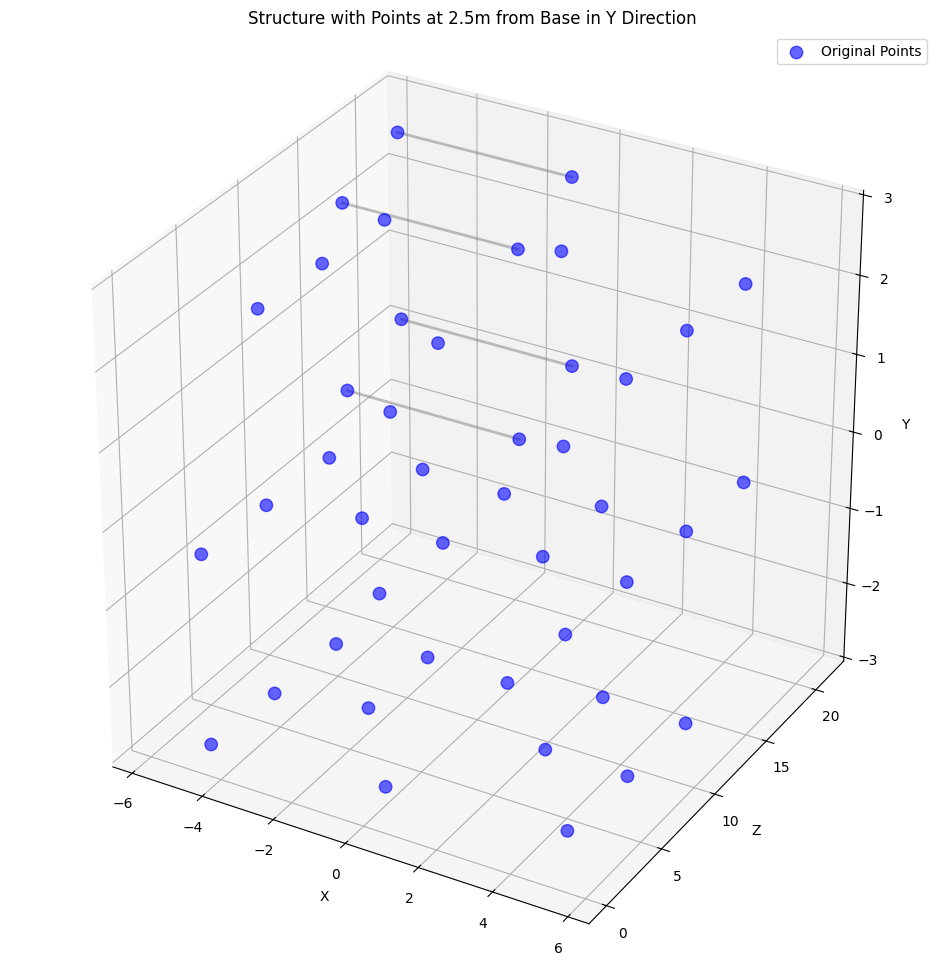

In [ ]:
# Create points at 2.5 units from the base in the Y axis on each edge
Floor_Height = 2.5
edge_points_at_offset = []

# For each unique connection (edge), find the point at Floor_Height from the base
for i, j in unique_connections:
    p1, p2 = points[i], points[j]
    
    # Check if this is primarily a vertical edge (Y direction)
    y_diff = abs(p2[1] - p1[1])
    x_diff = abs(p2[0] - p1[0])
    z_diff = abs(p2[2] - p1[2])
    
    # Only process edges that are primarily vertical (Y direction dominant)
    if y_diff > max(x_diff, z_diff) and y_diff > Floor_Height:
        # Find the base point (lower Y value) and top point (higher Y value)
        if p1[1] <= p2[1]:
            base_point = p1
            top_point = p2
        else:
            base_point = p2
            top_point = p1
        
        # Calculate the point at Floor_Height distance from base in Y direction only
        offset_point = base_point.copy()
        offset_point[1] += Floor_Height  # Move only in Y direction
        
        # Check if this point would be too close to existing points
        is_too_close = False
        tolerance = 0.5  # Minimum distance to existing points
        
        # Check against all existing points
        for existing_point in points:
            if np.linalg.norm(offset_point - existing_point) < tolerance:
                is_too_close = True
                break
        
        # Check against already added offset points
        for existing_offset in edge_points_at_offset:
            if np.linalg.norm(offset_point - existing_offset['point']) < tolerance:
                is_too_close = True
                break
        
        # Only add if not too close to existing points and within edge bounds
        if not is_too_close and offset_point[1] < top_point[1]:
            edge_points_at_offset.append({
                'point': offset_point,
                'edge': (i, j),
                'base_point': base_point,
                'top_point': top_point,
                'edge_length': np.linalg.norm(top_point - base_point)
            })

# Append the new edge points to nodes
for ep in edge_points_at_offset:
    unique_intersections.append({
        'point': ep['point'],
        'line1': ep['edge'],
        'line2': None,
        'line1_idx': None,
        'line2_idx': None
    })

print(f"Found {len(edge_points_at_offset)} points at {Floor_Height} units from base in Y direction")

# Visualize the structure with offset points
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot original points
ax.scatter(points[:, 0], points[:, 2], points[:, 1], 
          c='blue', s=80, alpha=0.6, label='Original Points')

# Plot edges
for i, j in unique_connections:
    p1, p2 = points[i], points[j]
    ax.plot([p1[0], p2[0]], [p1[2], p2[2]], [p1[1], p2[1]], 
            'gray', linewidth=2, alpha=0.5)

# Plot intersection points (nodes)
if unique_intersections:
    node_points = np.array([inter['point'] for inter in unique_intersections])
    ax.scatter(node_points[:, 0], node_points[:, 2], node_points[:, 1], 
              c='red', s=120, alpha=0.8, label='Nodes', marker='o')

# Plot points at offset
if edge_points_at_offset:
    offset_points_array = np.array([ep['point'] for ep in edge_points_at_offset])
    ax.scatter(offset_points_array[:, 0], offset_points_array[:, 2], offset_points_array[:, 1], 
              c='green', s=150, alpha=1.0, label=f'Points at {Floor_Height}m from base (Y-axis)', marker='s')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title(f'Structure with Points at {Floor_Height}m from Base in Y Direction')
ax.legend()
ax.set_box_aspect([1,1,1])

plt.show()

# Print details of offset points
for idx, ep in enumerate(edge_points_at_offset):
    print(f"Offset Point {idx+1}:")
    print(f"  Position: [{ep['point'][0]:.3f}, {ep['point'][1]:.3f}, {ep['point'][2]:.3f}]")
    print(f"  Edge: {ep['edge']}")
    print(f"  Y displacement from base: {ep['point'][1] - ep['base_point'][1]:.3f}")

Found 0 perpendicular connections between final nodes
Total final edges after adding perpendicular connections: 4


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

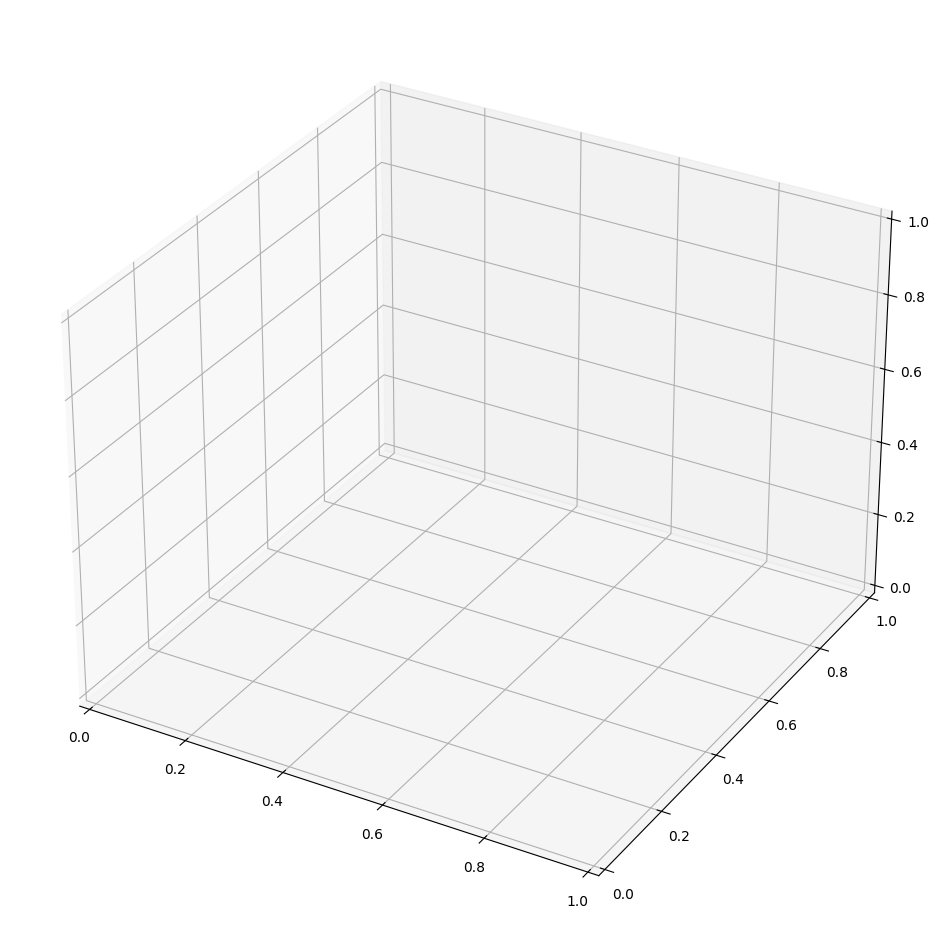

In [ ]:
# Connect points with their perpendicular opposites based on axis alignment
connections = []
final_nodes = unique_intersections
final_edges = unique_connections

# For each point in final_nodes, find its perpendicular opposite
for i, node_i in enumerate(final_nodes):
    point_i = node_i['point']
    x, y, z = point_i
    
    # Find points that share the same coordinates on two axes
    for j, node_j in enumerate(final_nodes):
        if i == j:
            continue
            
        point_j = node_j['point']
        ox, oy, oz = point_j
        
        # Check for perpendicular opposites (same on 2 axes, different on 1)
        same_axes = 0
        if abs(x - ox) < 1e-5:  # Same X
            same_axes += 1
        if abs(y - oy) < 1e-5:  # Same Y
            same_axes += 1
        if abs(z - oz) < 1e-5:  # Same Z
            same_axes += 1
            
        # If exactly 2 axes are the same, they are perpendicular opposites
        if same_axes == 2:
            # Avoid duplicate connections
            if (j, i) not in [(conn[1], conn[0]) for conn in connections]:
                connections.append((i, j))

print(f"Found {len(connections)} perpendicular connections between final nodes")

# Add these new connections to final_edges
for connection in connections:
    if connection not in final_edges:
        final_edges.append(connection)

print(f"Total final edges after adding perpendicular connections: {len(final_edges)}")

# Visualize the updated structure
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot all final nodes
final_node_points = np.array([node['point'] for node in final_nodes])
ax.scatter(final_node_points[:, 0], final_node_points[:, 2], final_node_points[:, 1], 
          c='red', s=120, alpha=0.8, label='Final Nodes', marker='o')

# Plot final edges (including new perpendicular connections)
for i, j in final_edges:
    p1, p2 = final_node_points[i], final_node_points[j]
    ax.plot([p1[0], p2[0]], [p1[2], p2[2]], [p1[1], p2[1]], 
            'blue', linewidth=2, alpha=0.7)

# Highlight new perpendicular connections
for i, j in connections:
    p1, p2 = final_node_points[i], final_node_points[j]
    ax.plot([p1[0], p2[0]], [p1[2], p2[2]], [p1[1], p2[1]], 
            'green', linewidth=3, alpha=0.9, label='New Perpendicular Connections' if i == connections[0][0] and j == connections[0][1] else "")

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('Final Structure with Perpendicular Connections')
ax.legend()
ax.set_box_aspect([1,1,1])

plt.show()

# Print connection details
print("\nNew perpendicular connections:")
for idx, (i, j) in enumerate(connections):
    p1, p2 = final_node_points[i], final_node_points[j]
    distance = np.linalg.norm(p2 - p1)
    print(f"Connection {idx+1}: Node {i} to Node {j}, Distance: {distance:.2f}")

In [ ]:
print(f"Final structure saved:")
print(f"Total final nodes: {len(final_nodes)}")
print(f"Total final edges: {len(connections)}")

Final structure saved:
Total final nodes: 24
Total final edges: 144


Original connections: 144
Total segments after division: 208


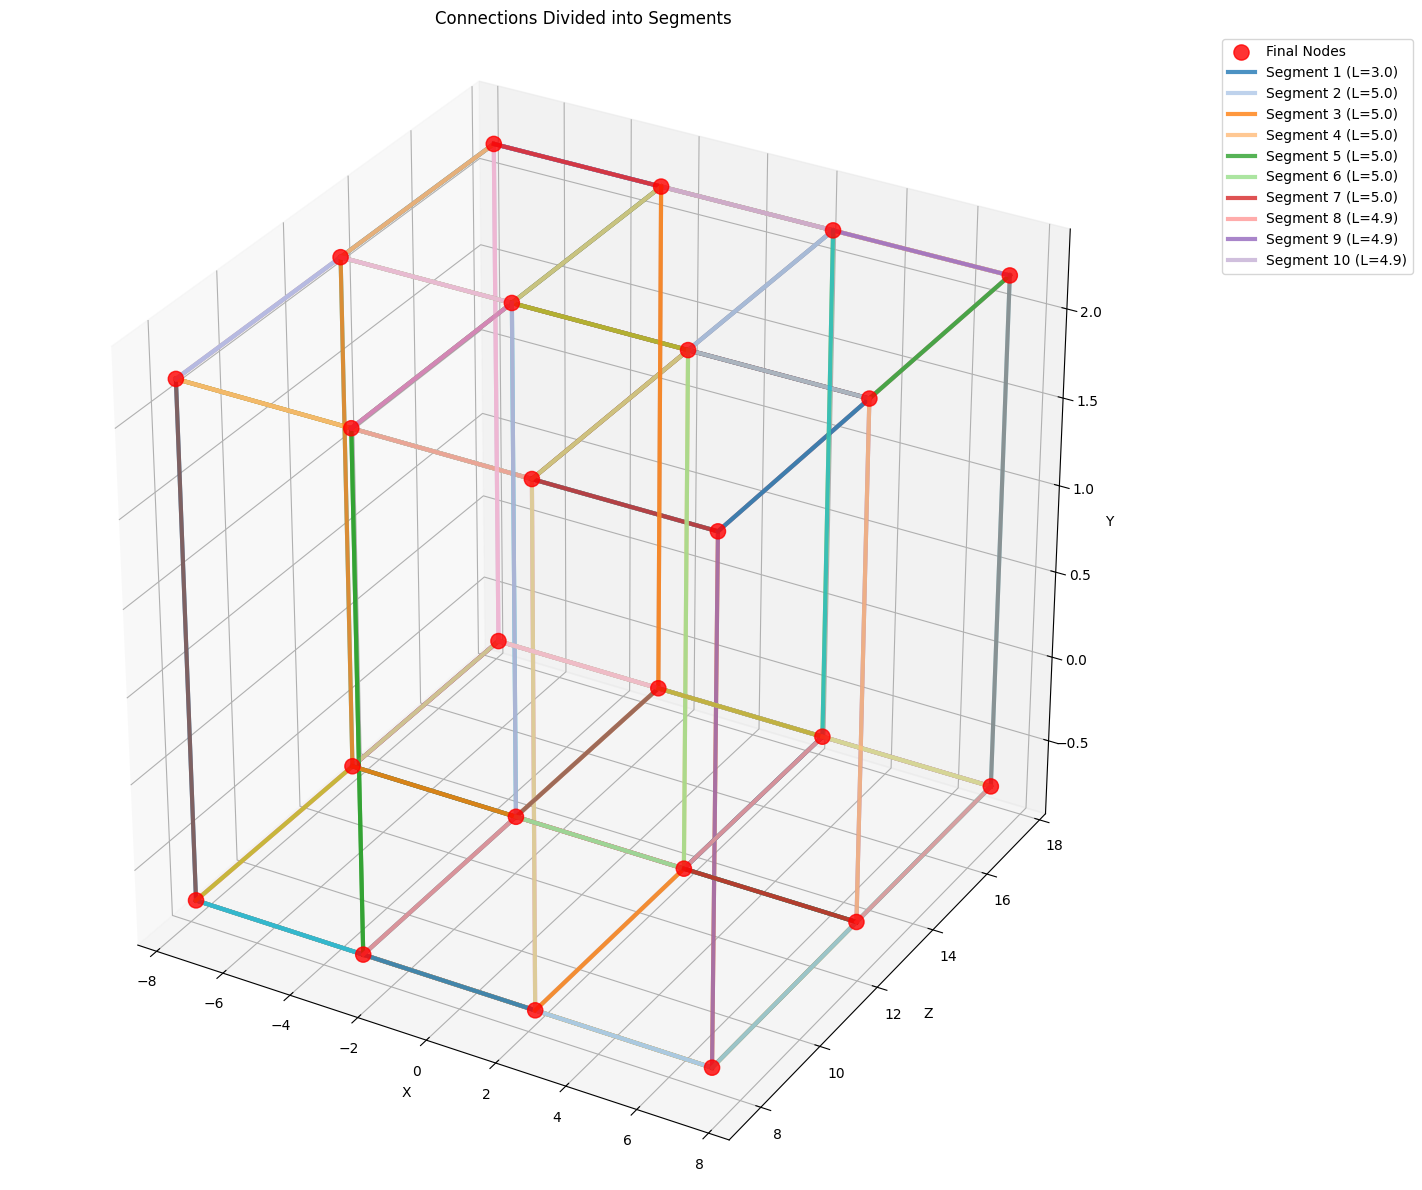


Segment Details:
Connection (0, 1): Single segment, Length = 2.95
Connection (0, 2): Single segment, Length = 4.99
Connection (0, 3): Divided into 2 segments
  Segment 1: Length = 4.99
  Segment 2: Length = 4.99
Connection (0, 4): Divided into 3 segments
  Segment 1: Length = 4.99
  Segment 2: Length = 4.99
  Segment 3: Length = 4.99
Connection (0, 5): Divided into 2 segments
  Segment 1: Length = 4.92
  Segment 2: Length = 4.92
Connection (0, 6): Single segment, Length = 4.92
Connection (1, 0): Single segment, Length = 2.95
Connection (1, 7): Divided into 3 segments
  Segment 1: Length = 4.99
  Segment 2: Length = 4.99
  Segment 3: Length = 4.99
Connection (1, 8): Divided into 2 segments
  Segment 1: Length = 4.99
  Segment 2: Length = 4.99
Connection (1, 9): Single segment, Length = 4.99
Connection (1, 10): Divided into 2 segments
  Segment 1: Length = 4.92
  Segment 2: Length = 4.92
Connection (1, 11): Single segment, Length = 4.92
Connection (2, 0): Single segment, Length = 4.99
C

In [ ]:
# Divide connections into segments based on final_nodes and visualize separate edges
def divide_connections_into_segments(connections, final_nodes, max_segment_length=6.0, min_segment_length=4.0):
    """
    Divide connections into segments based on length criteria
    """
    segmented_connections = []
    
    for conn_idx, (i, j) in enumerate(connections):
        p1 = final_nodes[i]['point']
        p2 = final_nodes[j]['point']
        length = np.linalg.norm(p2 - p1)
        
        if min_segment_length < length < max_segment_length:
            # Keep as single segment
            segmented_connections.append({
                'original_connection': (i, j),
                'segments': [{'start_node': i, 'end_node': j, 'start_point': p1, 'end_point': p2, 'length': length}]
            })
        elif length >= max_segment_length:
            # Divide into multiple segments
            num_divisions = int(np.ceil(length / max_segment_length))
            segments = []
            
            for seg_idx in range(num_divisions):
                t_start = seg_idx / num_divisions
                t_end = (seg_idx + 1) / num_divisions
                
                seg_start = p1 + t_start * (p2 - p1)
                seg_end = p1 + t_end * (p2 - p1)
                seg_length = np.linalg.norm(seg_end - seg_start)
                
                segments.append({
                    'start_node': i if seg_idx == 0 else None,  # Only first segment connects to original node
                    'end_node': j if seg_idx == num_divisions-1 else None,  # Only last segment connects to original node
                    'start_point': seg_start,
                    'end_point': seg_end,
                    'length': seg_length,
                    'segment_index': seg_idx
                })
            
            segmented_connections.append({
                'original_connection': (i, j),
                'segments': segments
            })
        else:
            # Length <= min_segment_length, keep as is
            segmented_connections.append({
                'original_connection': (i, j),
                'segments': [{'start_node': i, 'end_node': j, 'start_point': p1, 'end_point': p2, 'length': length}]
            })
    
    return segmented_connections

# Divide connections into segments
segmented_connections = divide_connections_into_segments(connections, final_nodes)

# Extract all individual segments for visualization
all_segments = []
for conn in segmented_connections:
    for segment in conn['segments']:
        all_segments.append(segment)

print(f"Original connections: {len(connections)}")
print(f"Total segments after division: {len(all_segments)}")

# Visualize the segmented connections
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot final nodes
final_node_points = np.array([node['point'] for node in final_nodes])
ax.scatter(final_node_points[:, 0], final_node_points[:, 2], final_node_points[:, 1], 
          c='red', s=120, alpha=0.8, label='Final Nodes', marker='o')

# Plot each segment with different colors
colors = plt.cm.tab20(np.linspace(0, 1, min(20, len(all_segments))))
for idx, segment in enumerate(all_segments):
    color = colors[idx % len(colors)]
    
    start_point = segment['start_point']
    end_point = segment['end_point']
    
    ax.plot([start_point[0], end_point[0]], 
            [start_point[2], end_point[2]], 
            [start_point[1], end_point[1]], 
            color=color, linewidth=3, alpha=0.8,
            label=f'Segment {idx+1} (L={segment["length"]:.1f})' if idx < 10 else "")

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('Connections Divided into Segments')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_box_aspect([1,1,1])

plt.tight_layout()
plt.show()

# Print segment details
print("\nSegment Details:")
for conn_idx, conn in enumerate(segmented_connections):
    if len(conn['segments']) > 1:
        print(f"Connection {conn['original_connection']}: Divided into {len(conn['segments'])} segments")
        for seg_idx, seg in enumerate(conn['segments']):
            print(f"  Segment {seg_idx+1}: Length = {seg['length']:.2f}")
    else:
        print(f"Connection {conn['original_connection']}: Single segment, Length = {conn['segments'][0]['length']:.2f}")

Created 416 separate nodes for segments
Created 208 separate connections

Separate Structural System Summary:
Total Nodes: 416
Total Beams: 184
Total Columns: 24
Total Connections: 208
Total Elements: 208


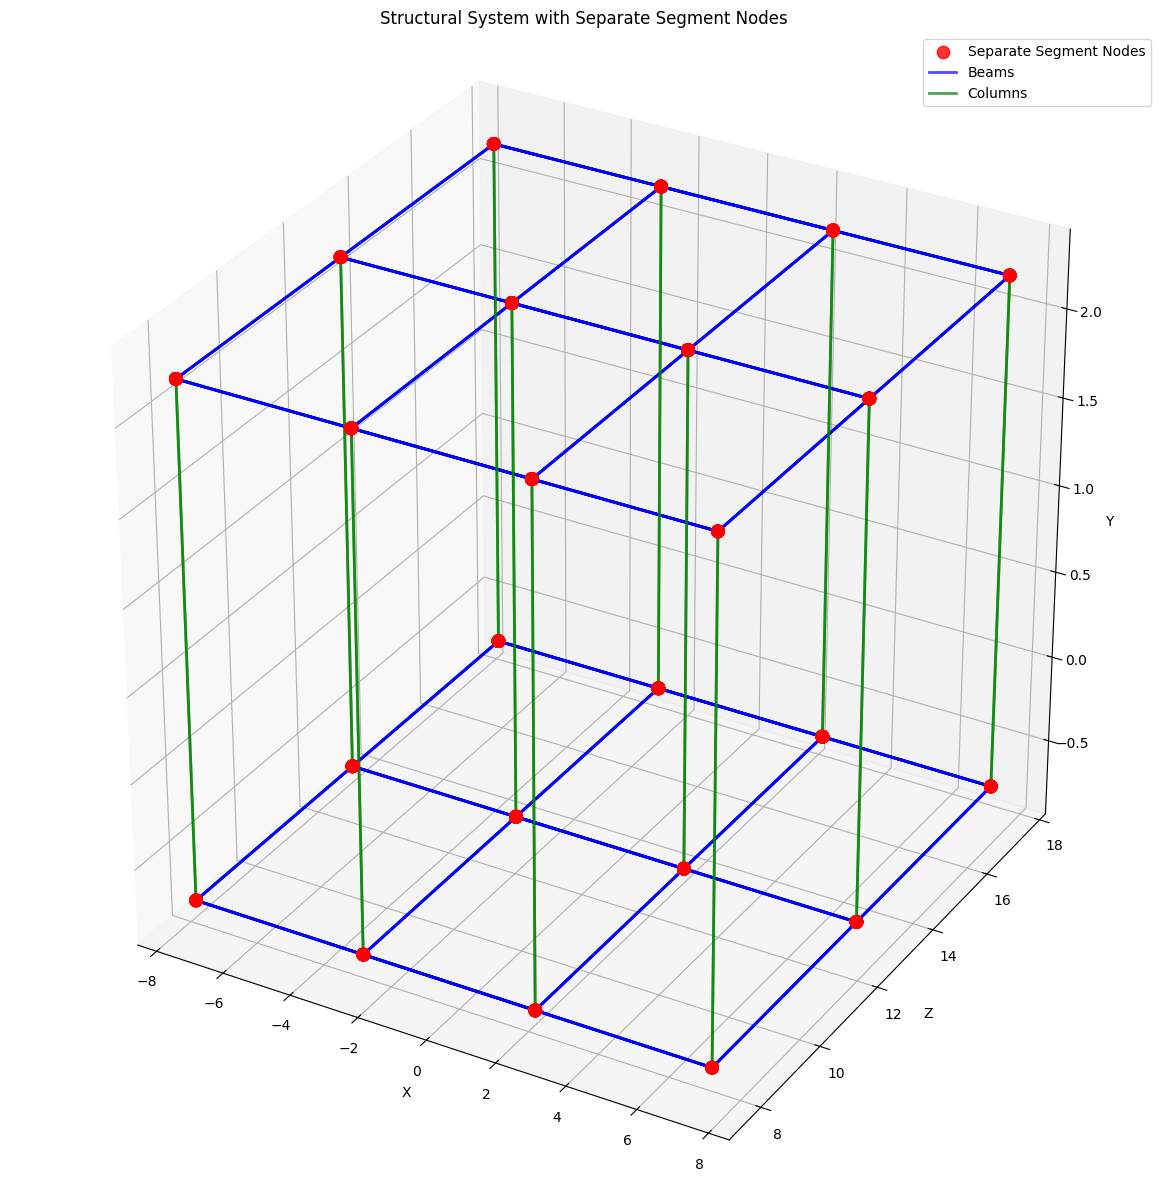

In [ ]:
# Create separate nodes for each segment to avoid overlapping
def create_separate_segment_nodes(all_segments):
    """
    Create separate nodes for each segment, ensuring no overlap between segments
    """
    segment_nodes = []
    segment_connections = []
    
    for idx, segment in enumerate(all_segments):
        # Create unique start and end nodes for each segment
        start_node = {
            'id': f'Node_Seg_{idx}_Start',
            'coordinates': segment['start_point'].copy(),
            'segment_id': idx,
            'node_type': 'segment_start'
        }
        
        end_node = {
            'id': f'Node_Seg_{idx}_End',
            'coordinates': segment['end_point'].copy(),
            'segment_id': idx,
            'node_type': 'segment_end'
        }
        
        # Add nodes to list
        segment_nodes.append(start_node)
        segment_nodes.append(end_node)
        
        # Create connection between start and end nodes of this segment
        start_node_idx = len(segment_nodes) - 2  # Index of start node
        end_node_idx = len(segment_nodes) - 1    # Index of end node
        
        segment_connections.append((start_node_idx, end_node_idx))
    
    return segment_nodes, segment_connections

# Create separate nodes and connections for all segments
separate_segment_nodes, separate_segment_connections = create_separate_segment_nodes(all_segments)

print(f"Created {len(separate_segment_nodes)} separate nodes for segments")
print(f"Created {len(separate_segment_connections)} separate connections")

# Create structural elements with separate nodes
separate_structural_beams = []
separate_structural_columns = []

for idx, segment in enumerate(all_segments):
    start_point = segment['start_point']
    end_point = segment['end_point']
    length = segment['length']
    
    # Determine if it's a beam or column based on direction
    direction_vector = end_point - start_point
    y_component = abs(direction_vector[1])
    xz_component = np.sqrt(direction_vector[0]**2 + direction_vector[2]**2)
    
    if y_component > xz_component:
        # Vertical element - Column
        element = {
            'id': f'Column_Seg_{idx}',
            'start_node_id': f'Node_Seg_{idx}_Start',
            'end_node_id': f'Node_Seg_{idx}_End',
            'start_point': start_point,
            'end_point': end_point,
            'length': length,
            'direction': 'vertical',
            'segment_index': idx
        }
        separate_structural_columns.append(element)
    else:
        # Horizontal element - Beam
        element = {
            'id': f'Beam_Seg_{idx}',
            'start_node_id': f'Node_Seg_{idx}_Start',
            'end_node_id': f'Node_Seg_{idx}_End',
            'start_point': start_point,
            'end_point': end_point,
            'length': length,
            'direction': 'horizontal',
            'segment_index': idx
        }
        separate_structural_beams.append(element)

# Create final structural system with separate nodes
separate_structural_system = {
    'nodes': separate_segment_nodes,
    'beams': separate_structural_beams,
    'columns': separate_structural_columns,
    'connections': separate_segment_connections,
    'summary': {
        'total_nodes': len(separate_segment_nodes),
        'total_beams': len(separate_structural_beams),
        'total_columns': len(separate_structural_columns),
        'total_connections': len(separate_segment_connections),
        'total_elements': len(separate_structural_beams) + len(separate_structural_columns)
    }
}

print(f"\nSeparate Structural System Summary:")
print(f"Total Nodes: {separate_structural_system['summary']['total_nodes']}")
print(f"Total Beams: {separate_structural_system['summary']['total_beams']}")
print(f"Total Columns: {separate_structural_system['summary']['total_columns']}")
print(f"Total Connections: {separate_structural_system['summary']['total_connections']}")
print(f"Total Elements: {separate_structural_system['summary']['total_elements']}")

# Visualize the separate segment structure
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot all separate nodes
node_coords = np.array([node['coordinates'] for node in separate_segment_nodes])
ax.scatter(node_coords[:, 0], node_coords[:, 2], node_coords[:, 1], 
          c='red', s=80, alpha=0.8, label='Separate Segment Nodes', marker='o')

# Plot beams
for beam in separate_structural_beams:
    start = beam['start_point']
    end = beam['end_point']
    ax.plot([start[0], end[0]], [start[2], end[2]], [start[1], end[1]], 
            'blue', linewidth=2, alpha=0.7, label='Beams' if beam == separate_structural_beams[0] else "")

# Plot columns
for column in separate_structural_columns:
    start = column['start_point']
    end = column['end_point']
    ax.plot([start[0], end[0]], [start[2], end[2]], [start[1], end[1]], 
            'green', linewidth=2, alpha=0.7, label='Columns' if column == separate_structural_columns[0] else "")

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('Structural System with Separate Segment Nodes')
ax.legend()
ax.set_box_aspect([1,1,1])

plt.tight_layout()
plt.show()

Cleaning structural system...

Cleaned Structural System Summary:
Total Nodes: 24 (removed 392)
Total Beams: 34 (removed 150)
Total Columns: 12 (removed 12)
Total Connections: 46
Total Elements: 46

Exported to: cleaned_structural_system.json


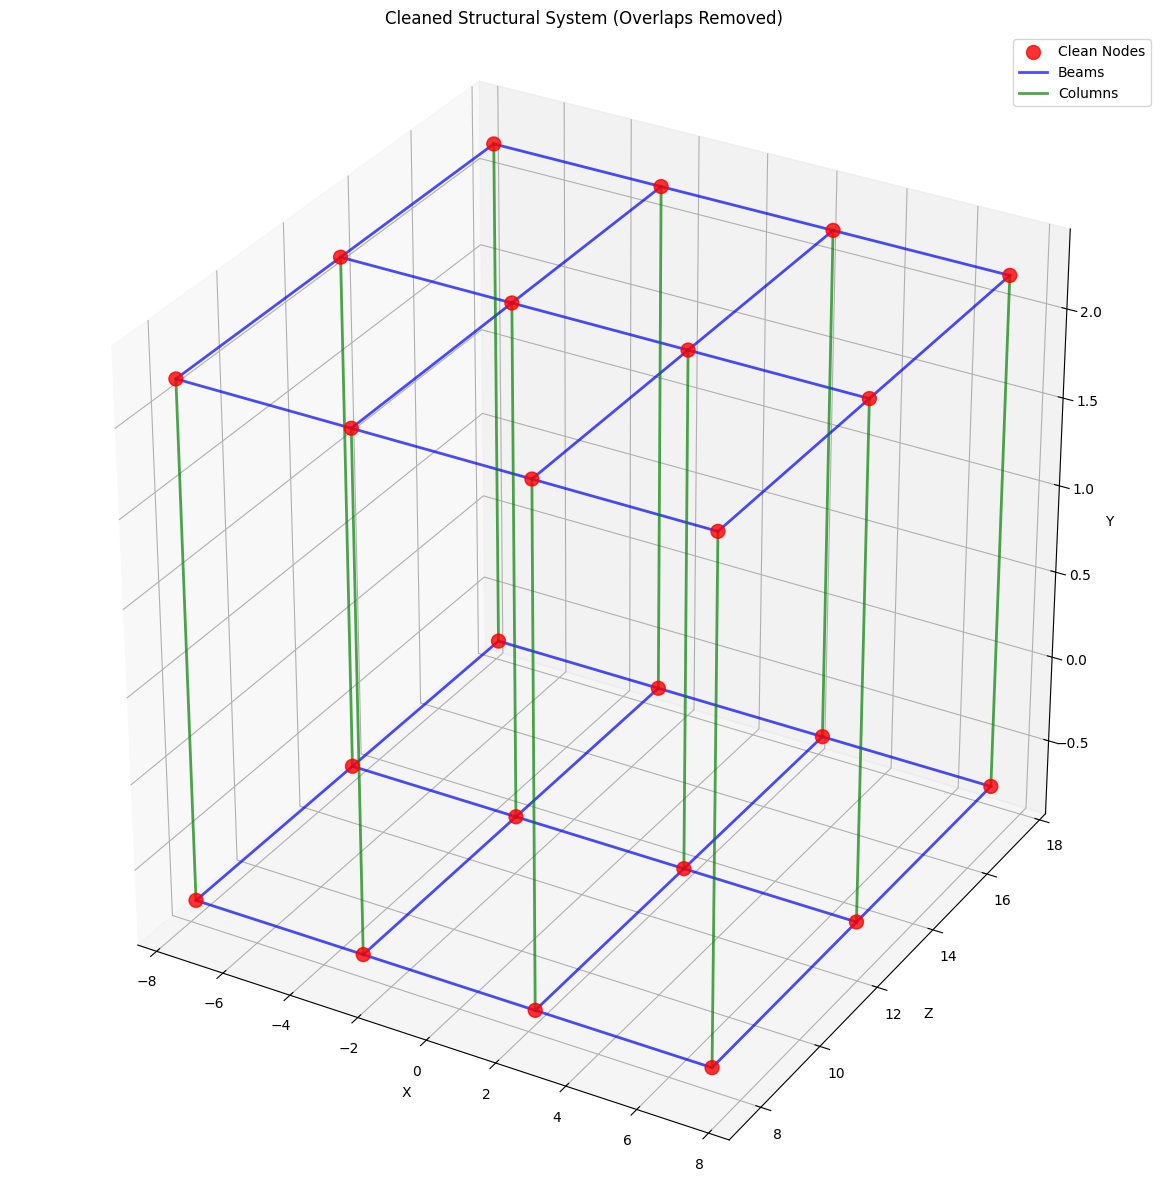

In [ ]:
import json

# Remove overlapping nodes with improved tolerance
def remove_overlapping_nodes(nodes, tolerance=1e-3):
    """Remove overlapping nodes based on coordinate proximity"""
    unique_nodes = []
    node_mapping = {}  # Map old indices to new indices
    
    for i, node in enumerate(nodes):
        coordinates = node['point'] if 'point' in node else node['coordinates']
        is_duplicate = False
        
        for j, existing_node in enumerate(unique_nodes):
            existing_coords = existing_node['point'] if 'point' in existing_node else existing_node['coordinates']
            distance = np.linalg.norm(np.array(coordinates) - np.array(existing_coords))
            
            if distance < tolerance:
                is_duplicate = True
                node_mapping[i] = j  # Map old index to existing node index
                break
        
        if not is_duplicate:
            node_mapping[i] = len(unique_nodes)
            # Create standardized node structure
            clean_node = {
                'id': f'Node_{len(unique_nodes) + 1}',
                'coordinates': coordinates.tolist() if hasattr(coordinates, 'tolist') else list(coordinates),
                'original_indices': [i]
            }
            unique_nodes.append(clean_node)
        else:
            # Add original index to existing node
            existing_idx = node_mapping[i]
            unique_nodes[existing_idx]['original_indices'].append(i)
    
    return unique_nodes, node_mapping

# Remove overlapping structural elements
def remove_overlapping_elements(elements, tolerance=1e-3):
    """Remove overlapping structural elements"""
    unique_elements = []
    
    for element in elements:
        start_coords = element['start_point']
        end_coords = element['end_point']
        
        is_duplicate = False
        for existing_element in unique_elements:
            existing_start = existing_element['start_point']
            existing_end = existing_element['end_point']
            
            # Check both directions for overlap
            dist1 = (np.linalg.norm(np.array(start_coords) - np.array(existing_start)) + 
                    np.linalg.norm(np.array(end_coords) - np.array(existing_end)))
            dist2 = (np.linalg.norm(np.array(start_coords) - np.array(existing_end)) + 
                    np.linalg.norm(np.array(end_coords) - np.array(existing_start)))
            
            if min(dist1, dist2) < tolerance:
                is_duplicate = True
                break
        
        if not is_duplicate:
            # Convert numpy arrays to lists for JSON serialization
            clean_element = element.copy()
            clean_element['start_point'] = start_coords.tolist() if hasattr(start_coords, 'tolist') else list(start_coords)
            clean_element['end_point'] = end_coords.tolist() if hasattr(end_coords, 'tolist') else list(end_coords)
            clean_element['length'] = float(clean_element['length'])
            unique_elements.append(clean_element)
    
    return unique_elements

# Clean the structural system
print("Cleaning structural system...")

# Clean nodes
clean_nodes, node_mapping = remove_overlapping_nodes(separate_structural_system['nodes'])

# Clean beams and columns
clean_beams = remove_overlapping_elements(separate_structural_system['beams'])
clean_columns = remove_overlapping_elements(separate_structural_system['columns'])

# Update connections based on node mapping
clean_connections = []
for connection in separate_structural_system['connections']:
    old_start, old_end = connection
    new_start = node_mapping.get(old_start, old_start)
    new_end = node_mapping.get(old_end, old_end)
    
    # Avoid self-connections and duplicates
    if new_start != new_end and (new_start, new_end) not in clean_connections and (new_end, new_start) not in clean_connections:
        clean_connections.append((new_start, new_end))

# Create final cleaned structural system
cleaned_structural_system = {
    'metadata': {
        'description': 'Cleaned structural system extracted from 3D model',
        'units': 'meters',
        'coordinate_system': 'XYZ',
        'created_date': str(pd.Timestamp.now()),
        'floor_height': Floor_Height
    },
    'nodes': clean_nodes,
    'beams': clean_beams,
    'columns': clean_columns,
    'connections': clean_connections,
    'summary': {
        'total_nodes': len(clean_nodes),
        'total_beams': len(clean_beams),
        'total_columns': len(clean_columns),
        'total_connections': len(clean_connections),
        'total_elements': len(clean_beams) + len(clean_columns),
        'original_nodes': len(separate_structural_system['nodes']),
        'original_beams': len(separate_structural_system['beams']),
        'original_columns': len(separate_structural_system['columns']),
        'nodes_removed': len(separate_structural_system['nodes']) - len(clean_nodes),
        'beams_removed': len(separate_structural_system['beams']) - len(clean_beams),
        'columns_removed': len(separate_structural_system['columns']) - len(clean_columns)
    }
}

# Export to JSON
output_filename = 'cleaned_structural_system.json'
with open(output_filename, 'w') as f:
    json.dump(cleaned_structural_system, f, indent=2, ensure_ascii=False)

print(f"\nCleaned Structural System Summary:")
print(f"Total Nodes: {cleaned_structural_system['summary']['total_nodes']} (removed {cleaned_structural_system['summary']['nodes_removed']})")
print(f"Total Beams: {cleaned_structural_system['summary']['total_beams']} (removed {cleaned_structural_system['summary']['beams_removed']})")
print(f"Total Columns: {cleaned_structural_system['summary']['total_columns']} (removed {cleaned_structural_system['summary']['columns_removed']})")
print(f"Total Connections: {cleaned_structural_system['summary']['total_connections']}")
print(f"Total Elements: {cleaned_structural_system['summary']['total_elements']}")
print(f"\nExported to: {output_filename}")

# Visualize the cleaned structure
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot cleaned nodes
node_coords = np.array([node['coordinates'] for node in clean_nodes])
ax.scatter(node_coords[:, 0], node_coords[:, 2], node_coords[:, 1], 
          c='red', s=100, alpha=0.8, label='Clean Nodes', marker='o')

# Plot cleaned beams
for beam in clean_beams:
    start = beam['start_point']
    end = beam['end_point']
    ax.plot([start[0], end[0]], [start[2], end[2]], [start[1], end[1]], 
            'blue', linewidth=2, alpha=0.7, label='Beams' if beam == clean_beams[0] else "")

# Plot cleaned columns
for column in clean_columns:
    start = column['start_point']
    end = column['end_point']
    ax.plot([start[0], end[0]], [start[2], end[2]], [start[1], end[1]], 
            'green', linewidth=2, alpha=0.7, label='Columns' if column == clean_columns[0] else "")

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('Cleaned Structural System (Overlaps Removed)')
ax.legend()
ax.set_box_aspect([1,1,1])

plt.tight_layout()
plt.show()

In [ ]:
import os

# Create the Server\Storage directory if it doesn't exist
storage_path = r".\Server\Storage"
os.makedirs(storage_path, exist_ok=True)

# Transform the cleaned structural system to the required format
formatted_structural_system = {
    "nodes": [],
    "columns": [],
    "beams": []
}

# Add nodes with the required format
for i, node in enumerate(cleaned_structural_system['nodes']):
    formatted_node = {
        "ID": f"N{i}",
        "X": round(node['coordinates'][0], 1),
        "Y": round(node['coordinates'][2], 1),  # Note: Z and Y are swapped in the format
        "Z": round(node['coordinates'][1], 1)
    }
    formatted_structural_system["nodes"].append(formatted_node)

# Add columns with the required format
for i, column in enumerate(cleaned_structural_system['columns']):
    # Find start and end node IDs based on coordinates
    start_coords = column['start_point']
    end_coords = column['end_point']
    
    start_node_id = None
    end_node_id = None
    
    # Find matching nodes for start and end points
    for node in formatted_structural_system["nodes"]:
        if (abs(node['X'] - start_coords[0]) < 0.1 and 
            abs(node['Y'] - start_coords[2]) < 0.1 and 
            abs(node['Z'] - start_coords[1]) < 0.1):
            start_node_id = node['ID']
        if (abs(node['X'] - end_coords[0]) < 0.1 and 
            abs(node['Y'] - end_coords[2]) < 0.1 and 
            abs(node['Z'] - end_coords[1]) < 0.1):
            end_node_id = node['ID']
    
    if start_node_id and end_node_id:
        formatted_column = {
            "ID": f"C{i}",
            "i_node": start_node_id,
            "j_node": end_node_id,
            "length": round(column['length'], 1)
        }
        formatted_structural_system["columns"].append(formatted_column)

# Add beams with the required format
for i, beam in enumerate(cleaned_structural_system['beams']):
    # Find start and end node IDs based on coordinates
    start_coords = beam['start_point']
    end_coords = beam['end_point']
    
    start_node_id = None
    end_node_id = None
    
    # Find matching nodes for start and end points
    for node in formatted_structural_system["nodes"]:
        if (abs(node['X'] - start_coords[0]) < 0.1 and 
            abs(node['Y'] - start_coords[2]) < 0.1 and 
            abs(node['Z'] - start_coords[1]) < 0.1):
            start_node_id = node['ID']
        if (abs(node['X'] - end_coords[0]) < 0.1 and 
            abs(node['Y'] - end_coords[2]) < 0.1 and 
            abs(node['Z'] - end_coords[1]) < 0.1):
            end_node_id = node['ID']
    
    if start_node_id and end_node_id:
        formatted_beam = {
            "ID": f"B{i}",
            "i_node": start_node_id,
            "j_node": end_node_id,
            "length": round(beam['length'], 1)
        }
        formatted_structural_system["beams"].append(formatted_beam)

# Save the formatted structural system to Server\Storage
output_filename = os.path.join(storage_path, 'structural_system.json')

with open(output_filename, 'w') as f:
    json.dump(formatted_structural_system, f, indent=4, ensure_ascii=False)

print(f"Formatted structural system saved to: {output_filename}")
print(f"File size: {os.path.getsize(output_filename)} bytes")
print(f"Total nodes: {len(formatted_structural_system['nodes'])}")
print(f"Total columns: {len(formatted_structural_system['columns'])}")
print(f"Total beams: {len(formatted_structural_system['beams'])}")

# Verify the file was created
if os.path.exists(output_filename):
    print("✓ File successfully saved to Server\\Storage directory")
else:
    print("✗ Error: File was not saved")

Formatted structural system saved to: .\Server\Storage\structural_system.json
File size: 9113 bytes
Total nodes: 24
Total columns: 12
Total beams: 34
✓ File successfully saved to Server\Storage directory
